In [1]:
from src.utils import cleaning, eda, config, sktools, metrics
from src.utils.classes import LogisticRegressionWithThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,\
                                MinMaxScaler, Normalizer, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, recall_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from collections import OrderedDict
import warnings 
import numpy as np
import pandas as pd
warnings.simplefilter('ignore')
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek

### Simple Data Cleaning

In [2]:
# Load the original dataset
df = cleaning.load_data(config.ORIG_DATA_PATH)
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [3]:
# Data cleaning
df = cleaning.drop_nan(df, verbose=True)

Dropped 24 rows, 0.13% of original rows


In [4]:
# Formatting index and column names
df = cleaning.format_data(df)
df.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [5]:
# Value counts file dump
cleaning.dump_value_counts(config.VALUE_COUNTS_PATH, df, verbose=True)

Value counts information has been printed to src/data/tmp/


In [6]:
# Save cleaned data
df.to_csv(config.CLEANED_DATA_PATH)

### EDA

In [7]:
# Load cleaned dataset
df = cleaning.load_data(config.CLEANED_DATA_PATH, index_col=0)
eda.report(df)

,nan_count,dtype,unique
offer_accepted,0,object,2
reward,0,object,3
mailer_type,0,object,2
income_level,0,object,3
bank_accounts_open,0,int64,3
overdraft_protection,0,object,2
credit_rating,0,object,3
credit_cards_held,0,int64,4
homes_owned,0,int64,3
household_size,0,int64,8


In [8]:
# Statistics of numerical features of the dataset
df.describe()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,1.255730,1.903427,1.203549,3.499110,940.515562,910.450656,999.392190,1042.033600,810.185803
std,0.472405,0.797086,0.427446,1.114476,350.297837,620.077060,457.402268,553.452599,559.001365
min,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000,363.000000
50%,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000,703.000000
75%,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000
max,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


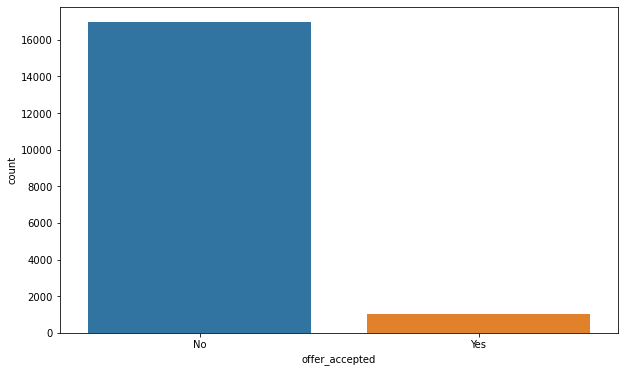

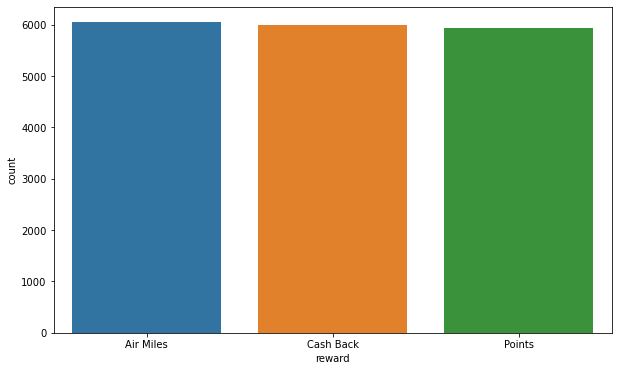

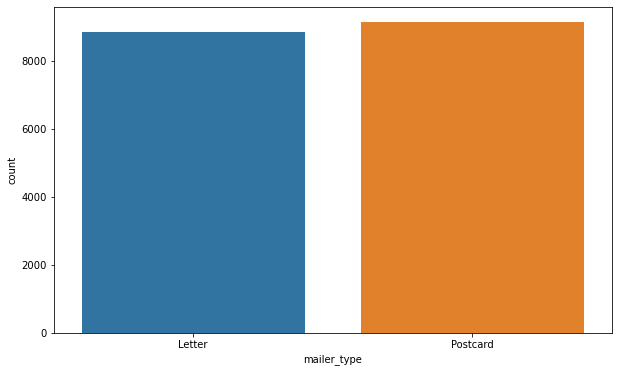

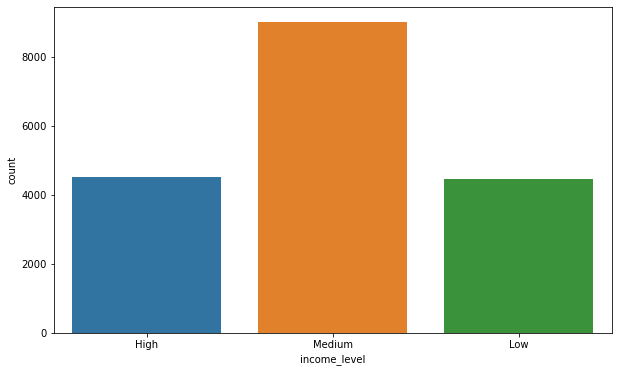

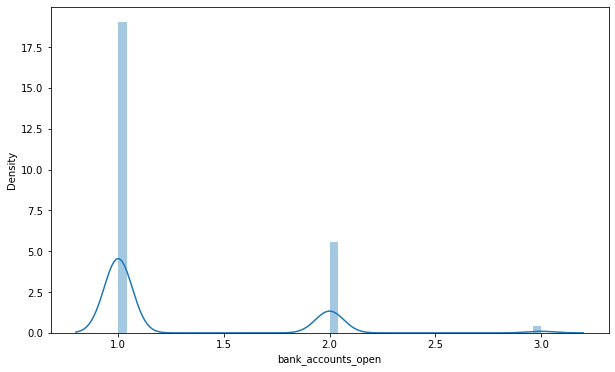

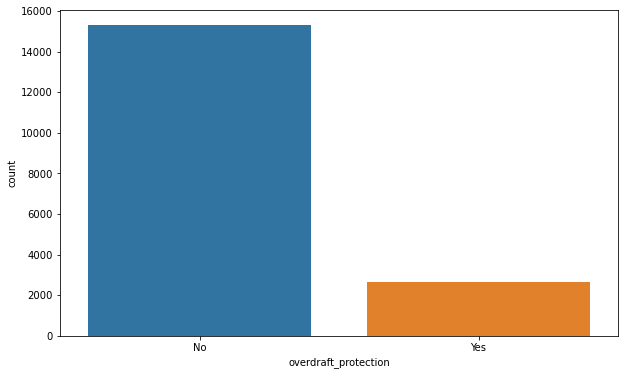

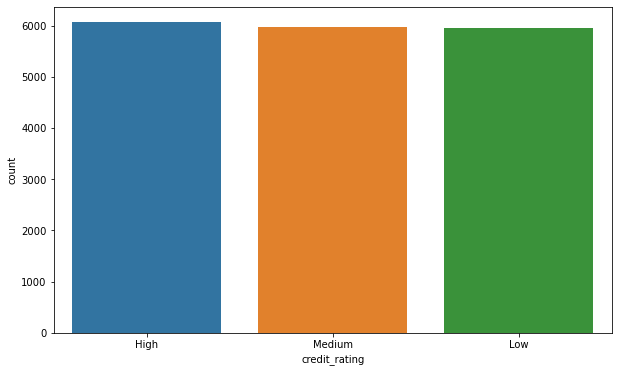

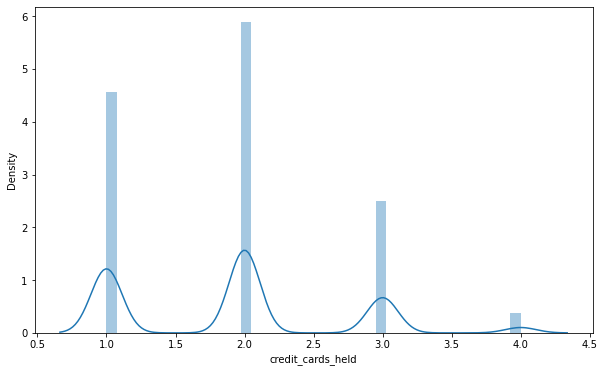

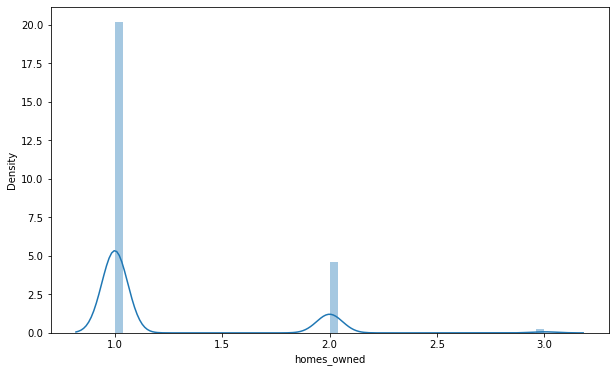

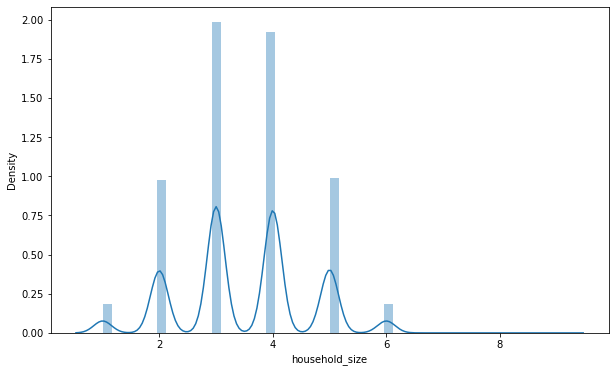

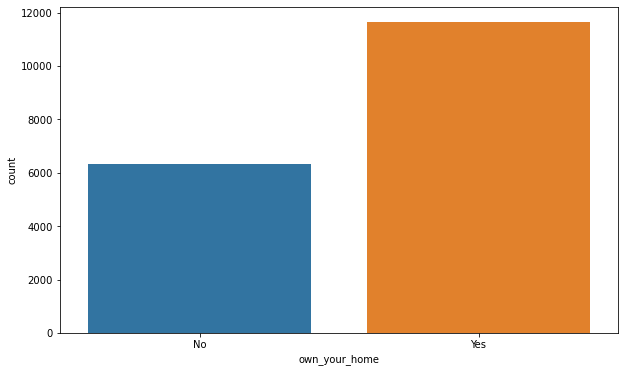

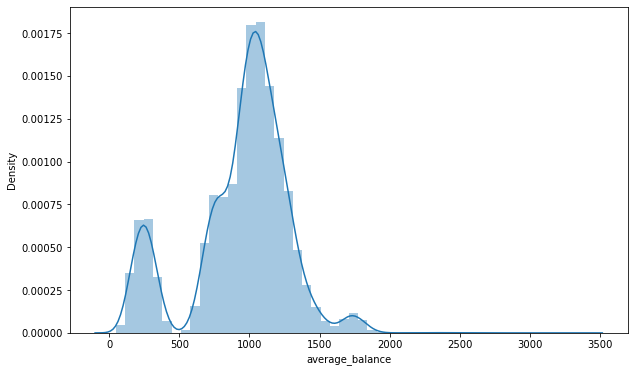

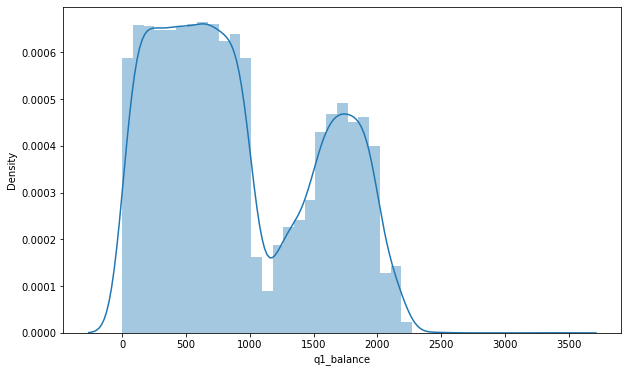

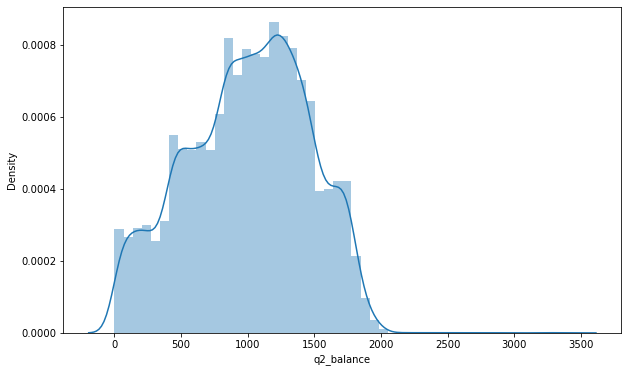

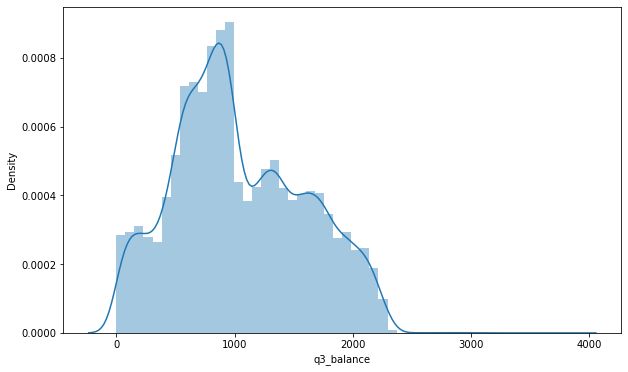

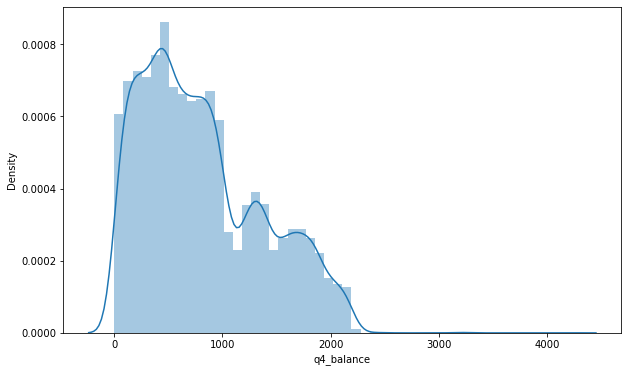

In [9]:
# Take a look at some distributions
eda.plot_distributions(df, (10, 6))

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

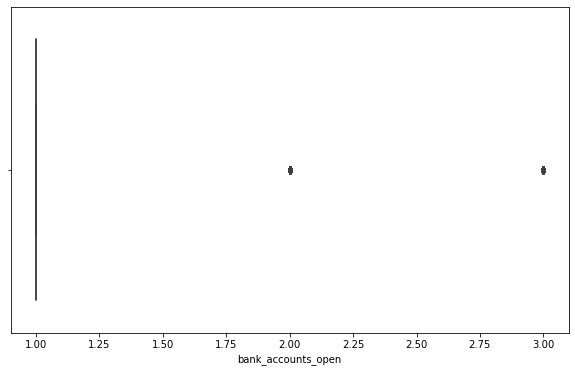

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

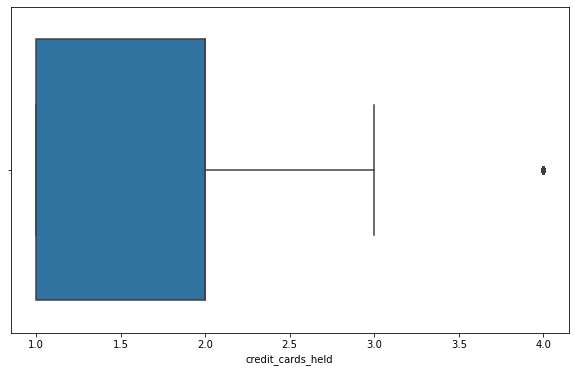

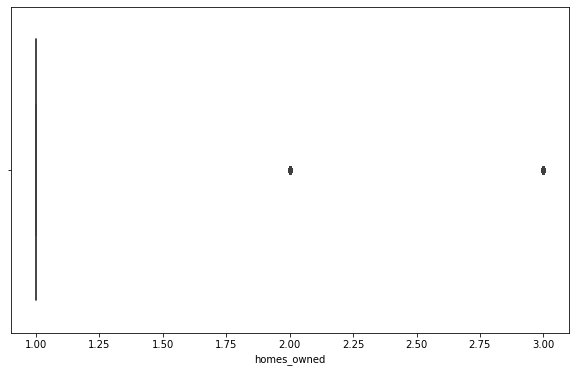

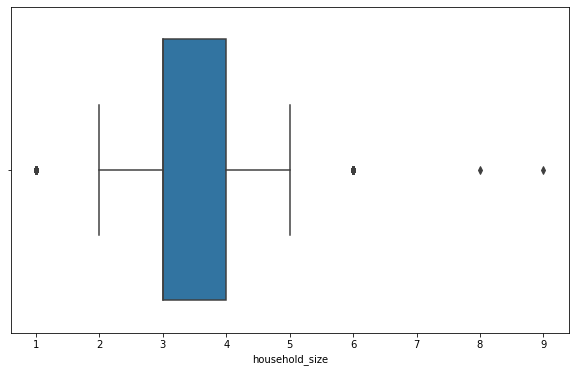

<Figure size 720x432 with 0 Axes>

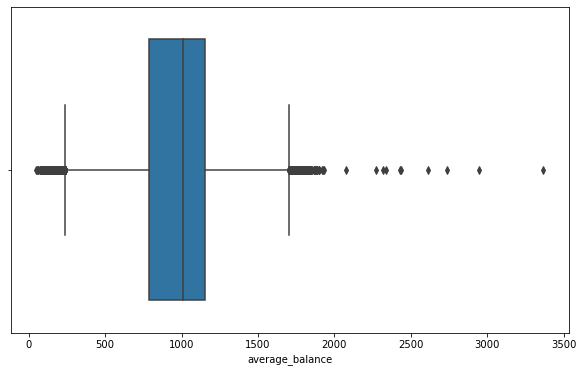

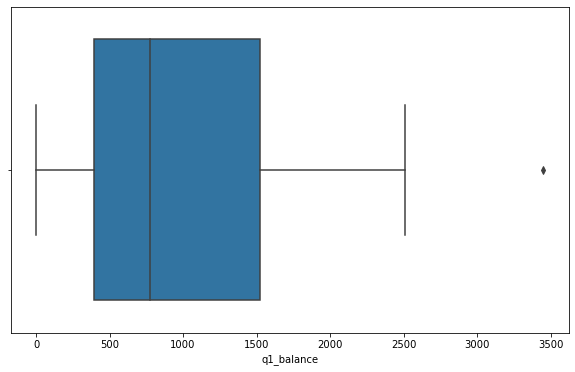

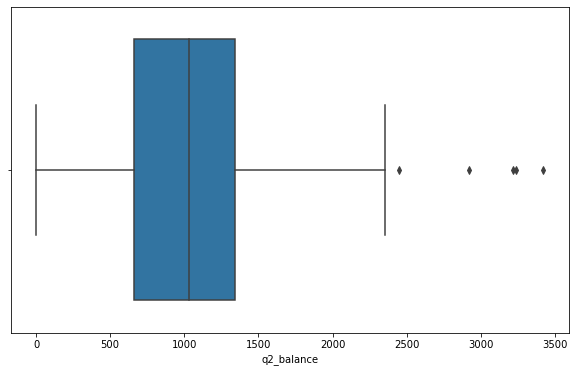

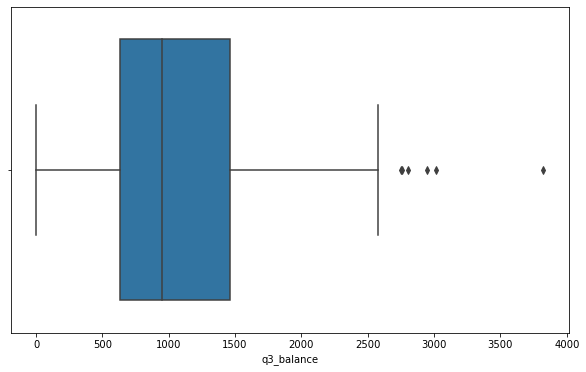

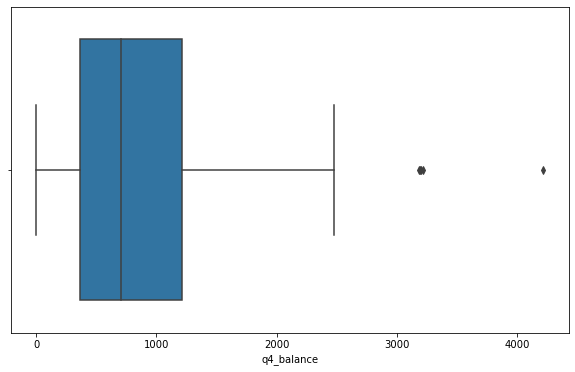

In [10]:
# Take a look to the outliers
eda.plot_outliers(df, (10, 6))

In [11]:
# drop outliers from selected columns
df_without_outliers = sktools.remove_outliers(df, skip_columns=eval(config.SKIP_DROP_OUTLIERS),
                                verbose=True, threshold=1.5)

Outliers removal has removed 1442 rows (8.02 % of initial size)


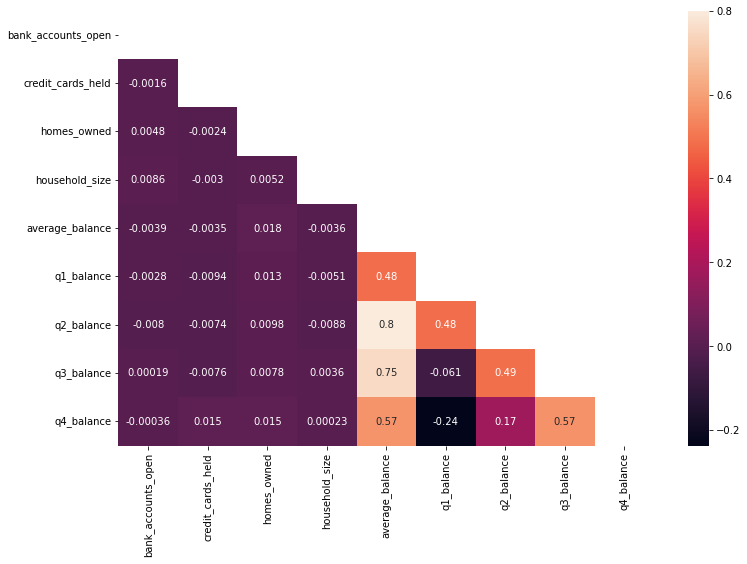

In [12]:
# Take a look to correlation heatmap
eda.show_corr_heatmap(df, figsize=(12, 8))

In [13]:
# Following couples present multicollinearity
multicoll = eda.report_multicoll(df)
multicoll

,feat1,feat2,corr
0,average_balance,q2_balance,0.800285
1,average_balance,q1_balance,0.481507
2,average_balance,q3_balance,0.752741
3,average_balance,q4_balance,0.572380
4,q1_balance,q2_balance,0.483134
5,q2_balance,q3_balance,0.487710
6,q3_balance,q4_balance,0.565298


### Benchmark Models
In following sections the Benchmark models are presented in order to get an <br>
initial idea on how the different classifiers perform with a raw dataset with <br>
minimal tuning to the model. The classifier analized are:
- Logistic Regression
- Naive Bayes (Multinomial)
- Naive Bayes (Gaussian)
- K-Neares Neighbors
- Support Vector Machine (SVC)
- Decision Tree (Random Forest Classifier)

Models are implemented all with the same modifications on the dataset:
- MinMax applied to numerical data
- One Hot Encoder applied to categorical data
- No feature engineer/reduction
- No consideration of Multicollinearity
- Yes balancing the dataset, otherwise all models due to high imbalance
- No outliers dropped
- No parameters tuning on the models

In [14]:
# Benchmark config
cols_onehot_encod = eval(config.COLS_ONEHOT_ENCODE) # TODO: declare explicitly
target = config.TARGET
models_bench = [LogisticRegression(), MultinomialNB(), GaussianNB(), KNeighborsClassifier(), 
          SVC(), RandomForestClassifier()]
scaler_bench = MinMaxScaler()
encoder_bench = OneHotEncoder()

In [15]:
# Benchmark models performances
y_true_bench, y_pred_bench = [], []
for model in models_bench:
    print('Model: ', str(model).strip('()')) 
    y_test, predictions, report = sktools.score_classification_model(
                                df=df,
                                target=target,
                                model=model,
                                cols_to_encode=[cols_onehot_encod],
                                scaler=scaler_bench,
                                encoders=[encoder_bench],
                                balance_dataset=True,
                                balancer=SMOTE()
    )
    y_true_bench.append(y_test)
    y_pred_bench.append(predictions)
    print(report, end='\n\n')

Model:  LogisticRegression
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.11      0.72      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.69      0.49      4494
weighted avg       0.93      0.67      0.76      4494


Model:  MultinomialNB
              precision    recall  f1-score   support

          No       0.98      0.66      0.79      4241
         Yes       0.12      0.74      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.70      0.49      4494
weighted avg       0.93      0.67      0.76      4494


Model:  GaussianNB
              precision    recall  f1-score   support

          No       0.97      0.70      0.82      4241
         Yes       0.12      0.65      0.20       253

    accuracy                           0.70      4494
   macro avg       0.54      0.68      0.51      4494
weig

How can we measure our models performance? We are interested obviously to have  <br>
an high recall on the 'Yes' class, meaning that we want to be sure to target all <br>
possible customers that will accept the card offer. <br>
However, during the following paragraphs it is possible to see that with the <br>
'high' recall comes a low 'precision' on the 'Yes' class. <br>
Let's take a look to recall and auc-roc score for these benchmark models below:

,model,recall_score
0,MultinomialNB(),0.73913
1,LogisticRegression(),0.72332
2,GaussianNB(),0.652174
3,SVC(),0.541502
4,KNeighborsClassifier(),0.304348
5,"(DecisionTreeClassifier(max_features='auto', r...",0.071146


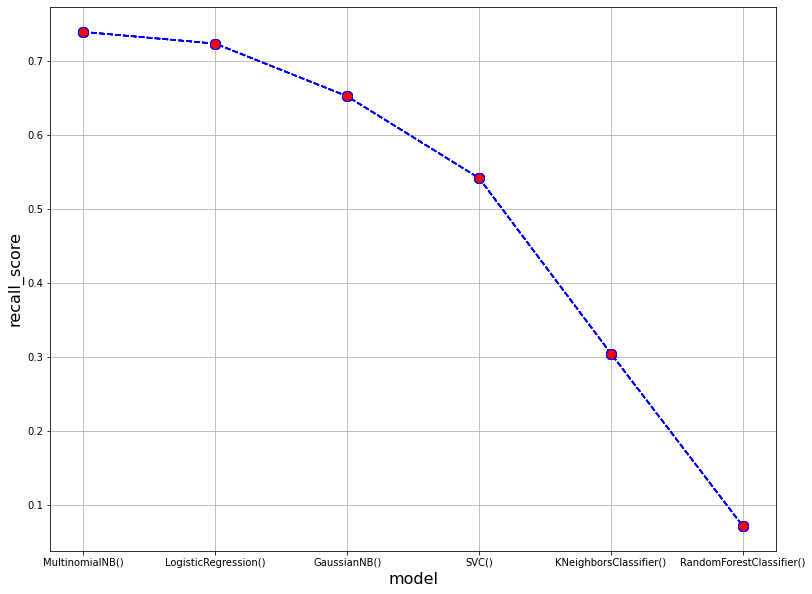

In [16]:
import importlib
importlib.reload(metrics)
params_bench = dict(model=models_bench)
metrics.report_metrics(params=params_bench,
                       metric=recall_score,
                       label='Yes',
                       all_true=y_true_bench,
                       all_pred=y_pred_bench,
                       sort_by_metric=True,
                       show_plot=True,
                       figsize=(13, 10),
                       )

### Models optimization
1. Scaling methods
2. Encoding methods
3. Outliers handling
4. Multicollinearity 
5. Balancing methods
6. ML model tuning

Logistic Regression and Naive Bayes (Multinomial) models seem to have the best <br> 
performance on the classification. <br>
Logistic Regression and Naive Bayes (Multinomial) will now be optimized and lastly <br>
a Grid Optimization will be tried on the SVC, Logistic Regression (and maybe Random forests) <br>


#### 1. Scaling Methods

In [17]:
# Parameters definition
scalers = [StandardScaler(), MinMaxScaler(), Normalizer(),
            FunctionTransformer(np.log)]
models = [LogisticRegression(), MultinomialNB()]
all_test, all_pred, all_reports = [], [], []

# Score models with different scalers and save the results
for model in models:
    for scaler in scalers:
        print('Model: ', str(model).strip('()')) 
        print('Scaler: ', str(scaler).strip('()'))
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=scaler,
                                    encoders=[OneHotEncoder()],
                                    balance_dataset=True,
                                    balancer=SMOTE(),
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  LogisticRegression
Scaler:  StandardScaler
              precision    recall  f1-score   support

          No       0.97      0.68      0.80      4241
         Yes       0.12      0.70      0.20       253

    accuracy                           0.68      4494
   macro avg       0.55      0.69      0.50      4494
weighted avg       0.93      0.68      0.77      4494


Model:  LogisticRegression
Scaler:  MinMaxScaler
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.11      0.72      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.70      0.50      4494
weighted avg       0.93      0.67      0.76      4494


Model:  LogisticRegression
Scaler:  Normalizer
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.12      0.75      0.20       253

    accuracy                     

,models,scalers,recall_score
0,LogisticRegression(),Normalizer(),0.750988
1,MultinomialNB(),MinMaxScaler(),0.743083
2,MultinomialNB(),Normalizer(),0.727273
3,MultinomialNB(),FunctionTransformer(func=<ufunc 'log'>),0.727273
4,LogisticRegression(),MinMaxScaler(),0.72332
5,LogisticRegression(),FunctionTransformer(func=<ufunc 'log'>),0.715415
6,LogisticRegression(),StandardScaler(),0.703557
7,MultinomialNB(),StandardScaler(),NaN


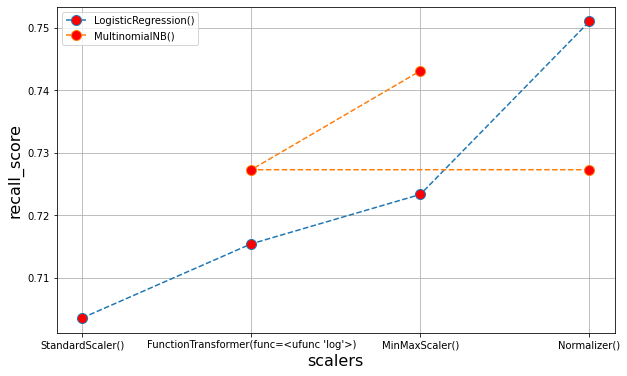

In [18]:
import importlib
importlib.reload(metrics)
# metrics report and plot for different scalers
params = OrderedDict(
    models = [LogisticRegression(), MultinomialNB()],
    scalers = [StandardScaler(), MinMaxScaler(), Normalizer(),
            FunctionTransformer(np.log)]
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

Seems like Normalization is slightly better for both reference model. <br>
Multinomial Naive Bayes needs only positive values in oreder to work,

#### 2. Encoding Methods

In [19]:
encoders = [OrdinalEncoder(), OneHotEncoder()]
models = [LogisticRegression(), MultinomialNB()]
all_test, all_pred, all_reports = [], [], []

# Scaler influence on models performance
for model in models:
    for encoder in encoders:
        print('Model: ', str(model).strip('()')) 
        print('Encoder: ', str(encoder).strip('()'))
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=Normalizer(),
                                    encoders=[encoder],
                                    balance_dataset=True,
                                    balancer=SMOTE()
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  LogisticRegression
Encoder:  OrdinalEncoder
              precision    recall  f1-score   support

          No       0.97      0.60      0.74      4241
         Yes       0.09      0.64      0.15       253

    accuracy                           0.60      4494
   macro avg       0.53      0.62      0.44      4494
weighted avg       0.92      0.60      0.70      4494


Model:  LogisticRegression
Encoder:  OneHotEncoder
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.12      0.74      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.71      0.50      4494
weighted avg       0.93      0.67      0.76      4494


Model:  MultinomialNB
Encoder:  OrdinalEncoder
              precision    recall  f1-score   support

          No       0.96      0.56      0.71      4241
         Yes       0.08      0.64      0.14       253

    accuracy                  

,models,encoders,recall_score
0,MultinomialNB(),OneHotEncoder(),0.754941
1,LogisticRegression(),OneHotEncoder(),0.743083
2,LogisticRegression(),OrdinalEncoder(),0.640316
3,MultinomialNB(),OrdinalEncoder(),0.640316


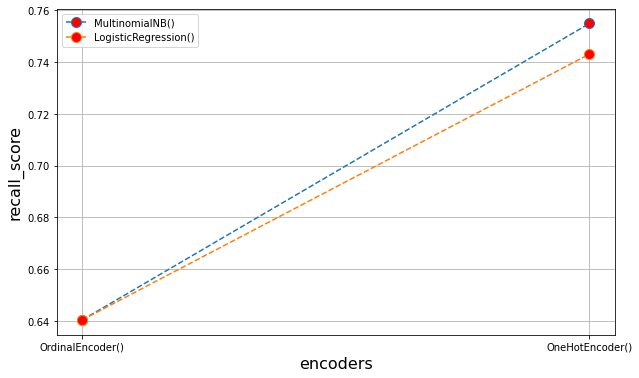

In [20]:
params = OrderedDict(
    models = [LogisticRegression(), MultinomialNB()],
    encoders = [OrdinalEncoder(), OneHotEncoder()]
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

The OneHotEncoder gives the best performance

#### 3. Multicollinearity

With multicollinearity accounted, I see strong relation with avg_balance and <br> all the q-balances. As a first measure I drop avg_balance and I keep only <br> q1 and q3 balances due to their low correlation factors (more distance <br> in time). Model increase precision from 0.20 to 0.25.

In [21]:
# Features with multicoll
eda.report_multicoll(df)

,feat1,feat2,corr
0,average_balance,q2_balance,0.800285
1,average_balance,q1_balance,0.481507
2,average_balance,q3_balance,0.752741
3,average_balance,q4_balance,0.572380
4,q1_balance,q2_balance,0.483134
5,q2_balance,q3_balance,0.487710
6,q3_balance,q4_balance,0.565298


We can try to drop *average_balance* and we also note that multicollinearity <br>
is present in consecutive quarter balance.

In [22]:
cols_to_drop_1 = []
cols_to_drop_2 = ['average_balance', 'q1_balance', 'q3_balance']
cols_to_drop_3 = ['average_balance', 'q2_balance', 'q4_balance']
cols_to_drop_4 = ['average_balance']
multicoll_drop = [cols_to_drop_1, cols_to_drop_2, cols_to_drop_3, cols_to_drop_4]

In [23]:
models = [LogisticRegression(), MultinomialNB()]
all_test, all_pred, all_reports = [], [], []

# Scaler influence on models performance
for model in models:
    for cols_to_drop in multicoll_drop:
        print('Model: ', str(model).strip('()')) 
        print('Cols dropped --> ',cols_to_drop)
        df_multicoll = df.drop(cols_to_drop, axis=1)
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df_multicoll,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=Normalizer(),
                                    encoders=[OneHotEncoder()],
                                    balance_dataset=True,
                                    balancer=SMOTE()
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  LogisticRegression
Cols dropped -->  []
              precision    recall  f1-score   support

          No       0.98      0.67      0.80      4241
         Yes       0.12      0.75      0.21       253

    accuracy                           0.68      4494
   macro avg       0.55      0.71      0.50      4494
weighted avg       0.93      0.68      0.76      4494


Model:  LogisticRegression
Cols dropped -->  ['average_balance', 'q1_balance', 'q3_balance']
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.12      0.75      0.21       253

    accuracy                           0.67      4494
   macro avg       0.55      0.71      0.50      4494
weighted avg       0.93      0.67      0.76      4494


Model:  LogisticRegression
Cols dropped -->  ['average_balance', 'q2_balance', 'q4_balance']
              precision    recall  f1-score   support

          No       0.98      0.67      0.80      4241
 

,models,cols_dropped,recall_score
0,LogisticRegression(),"[average_balance, q1_balance, q3_balance]",0.754941
1,MultinomialNB(),"[average_balance, q2_balance, q4_balance]",0.754941
2,LogisticRegression(),[],0.750988
3,LogisticRegression(),"[average_balance, q2_balance, q4_balance]",0.747036
4,LogisticRegression(),[average_balance],0.747036
5,MultinomialNB(),"[average_balance, q1_balance, q3_balance]",0.735178
6,MultinomialNB(),[average_balance],0.735178
7,MultinomialNB(),[],0.731225


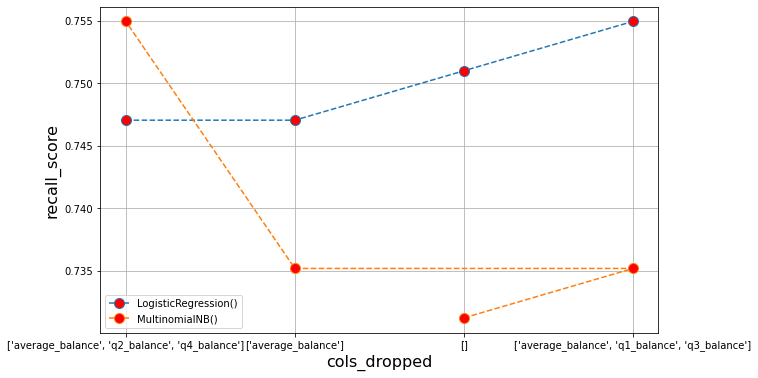

In [24]:
params = OrderedDict(
    models = [LogisticRegression(), MultinomialNB()],
    cols_dropped = multicoll_drop
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

#### 4. Outliers (threshold optimization)

In [25]:
# optimized parameters
# accounted multicoll
cols_to_drop = ['average_balance', 'q1_balance', 'q3_balance']
# model
models = [MultinomialNB(), LogisticRegression()]
# encoder
encoder = OneHotEncoder()
# scaler
scaler = Normalizer()
# reduced dataset
df_reduced = df.drop(cols_to_drop_2, axis=1)


In [26]:
# optimize on threshold for dropping outliers
thresholds = [None, 1.5, 2, 2.5, 3, 3.5]
skip_cols = ['bank_accounts_open', 'homes_owned', 'household_size']
all_test, all_pred, all_reports = [], [], []
for model in models:
    for threshold in thresholds:
        print('Model: ', str(model).strip('()')) 
        print('Threshold for outliers: ',threshold)
        df_reduced = df.drop(cols_to_drop, axis=1) # multicoll dropping
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df_multicoll,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=scaler,
                                    encoders=[encoder],
                                    outsiders_thresh=threshold,
                                    skip_outsiders_cols=skip_cols,
                                    balance_dataset=True,
                                    balancer=SMOTE()
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  MultinomialNB
Threshold for outliers:  None
              precision    recall  f1-score   support

          No       0.98      0.66      0.79      4241
         Yes       0.12      0.75      0.20       253

    accuracy                           0.66      4494
   macro avg       0.55      0.71      0.49      4494
weighted avg       0.93      0.66      0.75      4494


Model:  MultinomialNB
Threshold for outliers:  1.5
              precision    recall  f1-score   support

          No       0.98      0.64      0.77      4092
         Yes       0.12      0.77      0.21       271

    accuracy                           0.65      4363
   macro avg       0.55      0.70      0.49      4363
weighted avg       0.92      0.65      0.74      4363


Model:  MultinomialNB
Threshold for outliers:  2
              precision    recall  f1-score   support

          No       0.97      0.66      0.79      4092
         Yes       0.11      0.65      0.19       272

    accuracy                

,models,outliers_treshold,recall_score
0,MultinomialNB(),1.5,0.767528
1,MultinomialNB(),None,0.750988
2,LogisticRegression(),None,0.747036
3,MultinomialNB(),2.5,0.732824
4,LogisticRegression(),1.5,0.719557
5,LogisticRegression(),2.5,0.70229
6,MultinomialNB(),3.5,0.683453
7,LogisticRegression(),3.5,0.679856
8,LogisticRegression(),3,0.675182
9,MultinomialNB(),3,0.671533


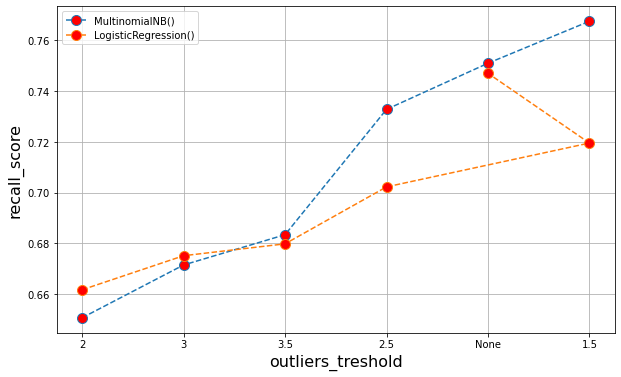

In [27]:
params = OrderedDict(
    models = [MultinomialNB(), LogisticRegression()],
    outliers_treshold = thresholds
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

Outliers should not be dropped

#### 5. Balancing Methods (Can SMOTE() be tuned? and Tomek Links?)

In [28]:
# till now, I have identified following optimal parameters
# accounted multicoll
cols_to_drop = ['average_balance', 'q1_balance', 'q3_balance']
# model
model = MultinomialNB()
# encoder
encoder = OneHotEncoder()
# scaler
scaler = Normalizer()
# reduced dataset
df_reduced = df.drop(cols_to_drop_2, axis=1)
# outliers
threshold = None

In [29]:
# optimize balancer
models = [MultinomialNB(), LogisticRegression()]
balancers = [SMOTE(), TomekLinks(), SMOTEENN(), SMOTETomek()]
all_test, all_pred, all_reports = [], [], []

for model in models:
    for balancer in balancers:
        print('Model: ', str(model).strip('()')) 
        print('Balancer: ', balancer)
        df_reduced = df.drop(cols_to_drop, axis=1) # multicoll dropping
        try:
            y_test, predictions, report = sktools.score_classification_model(
                                    df=df_multicoll,
                                    target=target,
                                    model=model,
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=scaler,
                                    encoders=[encoder],
                                    balance_dataset=True,
                                    balancer=balancer
            )
            print(report, end='\n\n')
            all_test.append(y_test)
            all_pred.append(predictions)
            all_reports.append(report)
        except:
            print('****FAILED****', end='\n\n')
            all_test.append(np.nan)
            all_pred.append(np.nan)
            all_reports.append(np.nan)

Model:  MultinomialNB
Balancer:  SMOTE()
              precision    recall  f1-score   support

          No       0.98      0.66      0.79      4241
         Yes       0.12      0.74      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.70      0.50      4494
weighted avg       0.93      0.67      0.76      4494


Model:  MultinomialNB
Balancer:  TomekLinks()
              precision    recall  f1-score   support

          No       0.94      1.00      0.97      4241
         Yes       0.00      0.00      0.00       253

    accuracy                           0.94      4494
   macro avg       0.47      0.50      0.49      4494
weighted avg       0.89      0.94      0.92      4494


Model:  MultinomialNB
Balancer:  SMOTEENN()
              precision    recall  f1-score   support

          No       0.98      0.60      0.74      4241
         Yes       0.11      0.80      0.19       253

    accuracy                           0.61      

,models,balancer,recall_score
0,MultinomialNB(),SMOTEENN(),0.802372
1,LogisticRegression(),SMOTEENN(),0.790514
2,LogisticRegression(),SMOTE(),0.747036
3,MultinomialNB(),SMOTE(),0.743083
4,LogisticRegression(),SMOTETomek(),0.743083
5,MultinomialNB(),SMOTETomek(),0.73913
6,MultinomialNB(),TomekLinks(),0.0
7,LogisticRegression(),TomekLinks(),0.0


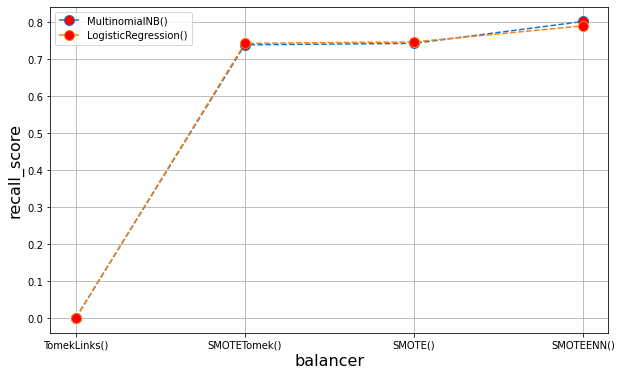

In [30]:
params = OrderedDict(
    models = [MultinomialNB(), LogisticRegression()],
    balancer = [SMOTE(), TomekLinks(), SMOTEENN(), SMOTETomek()]
)
metrics.report_metrics(params, recall_score, all_test, all_pred, label='Yes',
                        sort_by_metric=True, show_plot=True, hue='models')

SmoteTomek it is my choice. It works similiarly on both models. <br>
Tough fight betweem Logistic Regression and Naive Bayes classifier

#### 6. Logistic Regression optimization

In [31]:
# Preparing the model
X_train, X_test, y_train, y_test = sktools.split_data(df_reduced,
                                                        target = config.TARGET,
                                                        test_size=0.3,
                                                        random_state=42)
sktools.scale_data(X_train, X_test, scaler_class=Normalizer())
X_train, X_test = sktools.encode_data(X_train, X_test, encoders=[OneHotEncoder()],
                                        cols_to_encode=[cols_onehot_encod])
balancer = SMOTEENN()
X_train, y_train = balancer.fit_resample(X_train, y_train)

In [32]:
# Try an optimization of Logistic Regression
# define parameters
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
model=LogisticRegression()
grid = {'C': C, 'penalty': penalty}
clf = GridSearchCV(estimator=model,
                       param_grid=grid,
                       cv=5,
                       scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176870e-02,
       4.09491506e-02, 5.96362332e-02, 8.685113...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [33]:
print('Best C =', clf.best_estimator_.get_params().get('C'))
print('Best penalty =', clf.best_estimator_.get_params().get('penalty'))
C_opt =  clf.best_estimator_.get_params().get('C')

Best C = 719.6856730011514
Best penalty = l2


In [34]:
# Optimized Logistic Regression
y_test, predictions, report = sktools.score_classification_model(
                                    df=df_reduced,
                                    target=target,
                                    model=LogisticRegression(C=C_opt),
                                    cols_to_encode=[cols_onehot_encod],
                                    scaler=Normalizer(),
                                    encoders=[OneHotEncoder()],
                                    balance_dataset=True,
                                    balancer=SMOTEENN())
print(report)

              precision    recall  f1-score   support

          No       0.98      0.66      0.79      4241
         Yes       0.12      0.76      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.71      0.50      4494
weighted avg       0.93      0.67      0.76      4494



### 7. SVC optimization

In [35]:
# # Preparing the model
# X_train, X_test, y_train, y_test = sktools.split_data(df_reduced,
#                                                         target = config.TARGET,
#                                                         test_size=0.3,
#                                                         random_state=42)
# sktools.scale_data(X_train, X_test, scaler_class=Normalizer())
# X_train, X_test = sktools.encode_data(X_train, X_test, encoders=[OneHotEncoder()],
#                                         cols_to_encode=[cols_onehot_encod])
# balancer = SMOTETomek()
# X_train, y_train = balancer.fit_resample(X_train, y_train)

In [36]:
# # Try an optimization of SVC (this will take a long time)
# # define parameters
# grid = {'C': [0.1,1, 10, 100], 
#         'gamma': [1,0.1,0.01,0.001],
#         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

# model=SVC()
# clf = GridSearchCV(estimator=model,
#                        param_grid=grid,
#                        scoring='roc_auc',
#                        verbose=2)
# clf.fit(X_train, y_train)

# # save object with pickle for reusability

### Final Metrics of our model

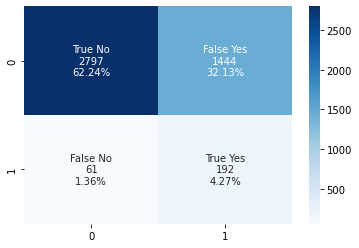

In [37]:
# Metrics of the chosen model
metrics.plot_confusion_matrix(y_test, predictions)

### Economic study

It seems we have found our model for our business problem. With the Logistic <br>
Regression algorithm we reach a recall (sensitivity) up to 76-77%. In these business <br>
problems recall is one of the most important parameter beacuse is more useful to try to <br>
find (predict) all the 'Yes' for the card-offer acceptance. Precision is low (0.11-0.12) <br>
and that implies that we are going to predict a lot of 'Yes' that are actually 'No'. <br>
Now that we have maximised the recall, we should find a trade-off to maximize revenue.


Let’s suppose the management team now give us the following information:
 - The database contains 1 M of customers.
 - The cost of sending an email is 12 c$.
 - The offer acceptance brings to the company 100$
 - Every true positive means we have encountered the potential customer and he/she will accept offer <br> bringing to the company (+100$ - 12c$)
 - Every true negative mean we have correctly not send an email to a customer that will not accept <br> the offer (0$)
 - Every false negative mean we have lost an opportunity with a potential customer (-100$)
 - Every false positive mean we sent an email to a customer that will not accept the offer (-12c$)



A stupid model will bring to the company:

In [38]:
n_customers = 10000 # $
customer_acceptance_gain = 10 # $
email_cost = 1 # $
historic_customer_acceptance_rate = df[target].value_counts()['Yes'] / (df[target].value_counts()['Yes'] +
                                                                         df[target].value_counts()['No'])
# a 'stupid' model sends email to all the customer and will get the historic rate of customer acceptance
revenue =  - email_cost*n_customers + historic_customer_acceptance_rate*n_customers*customer_acceptance_gain
print('Stupid model')
print('Revenue: ', round(revenue, 2), '$')

Stupid model
Revenue:  -4320.2 $


In [62]:
def calculate_revenue(y_test, predictions, n_customers, customer_acceptance_gain, email_cost):
    """Calculate revenue"""
    if pd.Series(y_test).unique().dtype in [int, 'int32', 'int64']:
        y_test = pd.Series(y_test).replace({0: 'No', 1: 'Yes'})
    if pd.Series(predictions).unique().dtype in [int, 'int32', 'int64']:
        predictions = pd.Series(predictions).replace({0: 'No', 1: 'Yes'})
    
    confusion = confusion_matrix(y_test, predictions)
    TP = confusion[1, 1]*n_customers/(len(y_test)) # True positive
    FP = confusion[0, 1]*n_customers/(len(y_test)) # False positive
    FN = confusion[1, 0]*n_customers/(len(y_test)) # False negative
    revenue = - email_cost*(TP+FP) - customer_acceptance_gain*(FN) + customer_acceptance_gain*(TP)
    return revenue

In [40]:
print('Benchmark optimized model:')
print(
    calculate_revenue(y_test, predictions, n_customers, customer_acceptance_gain, email_cost)
)

Benchmark optimized model:
-725.4116599910994


Optimized threshold for Logistic Regression

In [41]:
# Apply Logistic Regression with optimized parameters and optimized threshold
# Preparing the model
X_train, X_test, y_train, y_test = sktools.split_data(df_reduced,
                                                        target = config.TARGET,
                                                        test_size=0.3,
                                                        random_state=42)
sktools.scale_data(X_train, X_test, scaler_class=Normalizer())
X_train, X_test = sktools.encode_data(X_train, X_test, encoders=[OneHotEncoder()],
                                        cols_to_encode=[cols_onehot_encod])
balancer = SMOTEENN()
X_train, y_train = balancer.fit_resample(X_train, y_train)

0.36324335001932573 0.5820004771809566
tpr-fpr optimized model
-880.7713702948276
              precision    recall  f1-score   support

          No       0.98      0.55      0.71      5079
         Yes       0.10      0.83      0.18       314

    accuracy                           0.57      5393
   macro avg       0.54      0.69      0.44      5393
weighted avg       0.93      0.57      0.68      5393



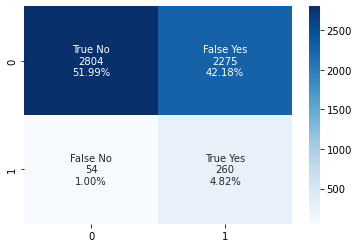

In [42]:
# Apply model optimized in tpr-fpr
model = LogisticRegressionWithThreshold()
model.fit(X_train, y_train)

threshold, optimal_tpr_minus_fpr = model.threshold_from_optimal_tpr_minus_fpr(X_train, y_train)
y_pred = model.predict(X_test, threshold)

print(threshold, optimal_tpr_minus_fpr)
metrics.plot_confusion_matrix(y_test, pd.Series(y_pred).replace({0: 'No', 1: 'Yes'}))

print('tpr-fpr optimized model')
print(
    calculate_revenue(y_test, y_pred, n_customers, customer_acceptance_gain, email_cost)
)
print(classification_report(y_test, pd.Series(y_pred).replace({0: 'No', 1: 'Yes'})))

0.9806152367315804 nan
f1 optimized model
-5794.548488781754
              precision    recall  f1-score   support

          No       0.94      1.00      0.97      5079
         Yes       0.20      0.00      0.01       314

    accuracy                           0.94      5393
   macro avg       0.57      0.50      0.49      5393
weighted avg       0.90      0.94      0.91      5393



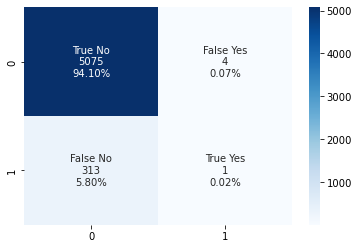

In [43]:
from src.utils import classes
import importlib
importlib.reload(classes)
from src.utils.classes import LogisticRegressionWithThreshold
# Apply model optimized in tpr-fpr
model = LogisticRegressionWithThreshold()
model.fit(X_train, y_train)

threshold, optimal_f1_score = model.threshold_from_optimal_f_score(X_train, y_train)
y_pred = model.predict(X_test, threshold)

print(threshold, optimal_f1_score)
metrics.plot_confusion_matrix(y_test, pd.Series(y_pred).replace({0: 'No', 1: 'Yes'}))

print('f1 optimized model')
print(
    calculate_revenue(y_test, y_pred, n_customers, customer_acceptance_gain, email_cost)
)
print(classification_report(y_test, pd.Series(y_pred).replace({0: 'No', 1: 'Yes'})))

In [68]:
from src.utils import classes
import importlib
importlib.reload(classes)
from src.utils.classes import LogisticRegressionWithThreshold
# Apply model optimized in tpr-fpr
model = LogisticRegressionWithThreshold()
model.fit(X_train, y_train)

threshold, max_cost, df_cost = model.threshold_from_cost_function(X_train, y_train,
                                                                 calculate_revenue,
                                                                 n_customers,
                                                                 customer_acceptance_gain,
                                                                 email_cost
                                                            )
y_pred = model.predict(X_test, threshold)

print(threshold, max_cost)
metrics.plot_confusion_matrix(y_test, pd.Series(y_pred).replace({0: 'No', 1: 'Yes'}))

# print('Revenue optimized model')
# print(
#     calculate_revenue(y_test, y_pred, n_customers, customer_acceptance_gain, email_cost)
# )
# print(classification_report(y_test, pd.Series(y_pred).replace({0: 'No', 1: 'Yes'})))

 11%|█▏        | 1655/14624 [01:14<09:43, 22.22it/s]


KeyboardInterrupt: 